In [ ]:
# This is a series of examples using the icanswim/qchem quantum mechanic machine learning repo
# icanswim/qchem utilizes the icanswim/cosmosis data science machine learning repo

In [1]:
import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../') 

from cosmosis.model import FFNet
from cosmosis.dataset import SKDS
from cosmosis.learning import Learn, Selector

from dataset import QM7, QM7b, QM7X, ANI1x, QM9, PGDS
from model import pyg_model, GraphNet

from torch.optim import Adam
from torch.nn import MSELoss, L1Loss, NLLLoss, CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch_geometric.loader import DataLoader


RDKit WARNING: [23:23:40] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
#example exploring cosmosis/qchem QM9 dataset with rdkit data augmentation

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['atomic_number','aromatic',
                                                                   'degree','charge'],
                                                             'embed': ['hybridization','chirality'],
                                                             'coulomb': ['coulomb'],
                                                             'edge_index': ['edge_indices'],
                                                            },
                                             'criterion_input': {'target': ['U0']}},
                              'n': 10000,
                              'db': 'rdkit',
                              'n_conformers': 1,
                              'pad': False,
                              'pad_feats': ['mulliken','coulomb','aromatic','degree',
                                            'charge','n_hs','n_rads','atomic_number',
                                            'hybridization','chirality'],
                              'as_tensor': False,
                              'filter_on': ('n_atoms','<','18'),
                              'use_pickle': 'qm9_test.p',
                              'flatten': False}}

qm9 = QM9(**ds_params['train_params'])
qm9[1]

loading QM9 datadic from a pickled copy...
CDataset created...


{'model_input': {'X': array([6., 1., 1., 1., 1., 0., 0., 0., 0., 0., 4., 1., 1., 1., 1., 0., 0.,
         0., 0., 0.], dtype=float32),
  'embed': [array([5, 1, 1, 1, 1]), array([1, 1, 1, 1, 1])],
  'coulomb': array([[36.858112  , 10.543005  , 10.838454  , 10.8277    , 10.311594  ],
         [ 0.90403795,  0.5       ,  1.8064089 ,  1.8046168 ,  1.7185988 ],
         [ 0.90403795,  1.7571673 ,  0.5       ,  1.8046168 ,  1.7185988 ],
         [ 0.90403795,  1.7571673 ,  1.8064089 ,  0.5       ,  1.7185988 ],
         [ 0.90403795,  1.7571673 ,  1.8064089 ,  1.8046168 ,  0.5       ]],
        dtype=float32),
  'edge_index': array([[0, 1],
         [1, 0],
         [0, 2],
         [2, 0],
         [0, 3],
         [3, 0],
         [0, 4],
         [4, 0]])},
 'criterion_input': {'target': array([-40.47893], dtype=float32)}}

In [3]:
#example exploring cosmosis/qchem QM9 dataset with rdkit data augmentation
l, s, li, si = 0, 9999, 0, 0
for i in qm9.ds_idx:
    d = qm9[i]['model_input']['X'].shape[0]
    if d > l:
        l = d
        li = i
    if d < s:
        s = d
        si = i
print('longest molecule index: ', li, ' length: ', l)
print('shortest molecule index: ', si, ' length: ', s)
qm9[si]

longest molecule index:  5806  length:  104
shortest molecule index:  3  length:  12


{'model_input': {'X': array([8., 1., 1., 0., 0., 0., 2., 1., 1., 0., 0., 0.], dtype=float32),
  'embed': [array([5, 1, 1]), array([1, 1, 1])],
  'coulomb': array([[73.51671  , 34.509003 , 34.45475  ],
         [ 1.0017037,  0.5      ,  4.3068438],
         [ 1.0017037,  4.3136253,  0.5      ]], dtype=float32),
  'edge_index': array([[0, 1],
         [1, 0],
         [0, 2],
         [2, 0]])},
 'criterion_input': {'target': array([-76.4047], dtype=float32)}}

In [4]:
#example exploring cosmosis/qchem PyG dataset wrapper with Data object output
import numpy as np
ds_params = {'train_params': {'dataset': 'QM9',
                              'pg_params': {'root': './data/'}}}

pgds = PGDS(**ds_params['train_params'])
ds_idx = np.arange(1000)
selector = Selector(train_idx=ds_idx)
selector('train')
loader = DataLoader(pgds, batch_size=2, sampler=selector)
batch = next(iter(loader))
print(batch)
print(batch.ptr)
print(batch.idx)
print(batch.x)
print(pgds[1])
print(pgds[1].x)
print(pgds[1].idx)

creating pytorch geometric QM9 dataset...
CDataset created...
Batch(x=[20, 11], edge_index=[2, 38], edge_attr=[38, 4], y=[2, 19], pos=[20, 3], z=[20], name=[2], idx=[2], batch=[20], ptr=[3])
tensor([ 0,  9, 20])
tensor([440, 243])
tensor([[0., 0., 0., 1., 0., 8., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [0., 0., 1., 0., 0., 7., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 8., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 3.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 8., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 8., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.],
        [0., 

In [5]:
#example exploring cosmosis/qchem PyG dataset wrapper, padded with dictionary output
ds_params = {'train_params': {'dataset': 'QM9',
                              'use_pyg': False,
                              'pad': (29,11),
                              'pad_feats': ['x'],
                              'flatten': False,
                              'input_dict': {'model_input': {'X': ['x']},
                                             'criterion_input': {'target': ['y']}},
                              'pg_params': {'root': './data/'}}}

pgds = PGDS(**ds_params['train_params'])
pgds[1]

creating pytorch geometric QM9 dataset...
CDataset created...


{'model_input': {'X': tensor([[0., 0., 1., 0., 0., 7., 0., 0., 0., 0., 3.],
          [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
          [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
          [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0

loading QM9 datadic from a pickled copy...
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:04.969609
epoch: 0, lr: 0.01
train loss: 355.50449829101564, val loss: 353.8243408203125
learning time: 0:00:15.055165
epoch: 8, lr: 0.01
train loss: 47.78565216064453, val loss: 61.08023452758789
test loss: 30.124879837036133
learning time: 0:00:16.884816


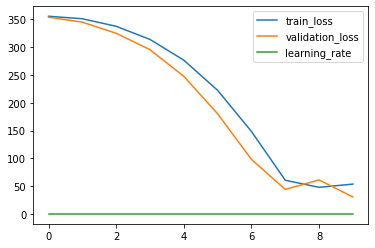

In [6]:
#example cosmosis/qchem QM9 dataset with filter, rdkit data augmentation, 
#embeddings and custom model 
rdkit_features = ['atom_type','atomic_number','aromatic','chirality',
                  'degree','charge','n_hs','n_rads','hybridization',
                  'edge_indices','edge_attr','rdmol_block','n_atoms',
                  'xyz','distance','coulomb','adjacency','rdmol']

rdkit_edge = ['edge_indices','edge_attr']

qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['aromatic','degree',
                                                                   'charge','coulomb'],
                                                             'embed': ['hybridization','chirality']},
                                             'criterion_input': {'target': ['U0']}},
                              #'n': 10000, #non-random for testing
                              'db': 'rdkit',
                              'n_conformers': 1,
                              'pad': 29,
                              'pad_feats': ['mulliken','coulomb','aromatic','degree',
                                            'charge','n_hs','n_rads','atomic_number',
                                            'hybridization','chirality'],
                              'as_tensor': True,
                              'filter_on': ('n_atoms','>','10'), #filter out molecules with less than 10 atoms
                              'use_pickle': 'qm9_test.p',
                              'flatten': True}}


model_params = {'in_channels': 29+29+29+29*29+29*16+29*16, 
                'hidden': 4096, 
                'out_channels': 1, 
                'model_name': 'funnel',
                'embed_params': [('hybridization',9,16,0,True),('chirality',5,16,0,True)]
               }
                
metrics_params = {'report_interval': 1,
                  'log_plot': False}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15),
                 'subset': .2 #create random subset
                }

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM9], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          batch_size=256, epochs=10)

creating pytorch geometric TUDataset dataset...
CDataset created...
GNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:00.744910
epoch: 0, lr: 0.01
train loss: 0.08213378069922328, val loss: 0.07205936561028163
sklearn train metric: 0.6328125, sklearn validation metric: 0.75
learning time: 0:00:06.129738
epoch: 8, lr: 0.01
train loss: 0.06641334318555892, val loss: 0.067288422336181
sklearn train metric: 0.7734375, sklearn validation metric: 0.7916666666666666
test loss: 0.07233631610870361
learning time: 0:00:07.086205
sklearn test metric: 
0.6666666666666666 



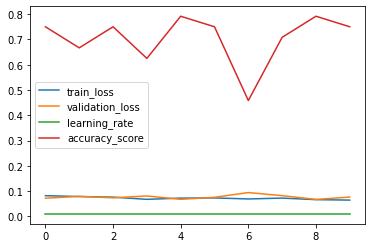

In [7]:
#example cosmosis/qchem PyG dataset wrapper with Data object output and
#sklearn metrics and custom PyG model

model_params = {'in_channels': 7,
                'hidden': 64,
                'out_channels': 2}

ds_params = {'train_params': {'dataset': 'TUDataset',
                              'use_pyg': True,
                              'pg_params': {'root': './data/',
                                            'name': 'MUTAG'}}}

metrics_params = {'report_interval': 5,
                  'log_plot': False,
                  'sk_metric_name': 'accuracy_score',
                  'sk_params': {}}

opt_params = {'lr': 0.01}

crit_params = {}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}

l = Learn([PGDS], GraphNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=CrossEntropyLoss, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=8, epochs=10)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:07.681883
epoch: 0, lr: 0.01
train loss: 481.63168569506047, val loss: 19.071337034827785
learning time: 0:00:23.146188
epoch: 2, lr: 0.01
train loss: 12.531242926247648, val loss: 12.041052906136764
learning time: 0:00:38.780920
epoch: 4, lr: 0.01
train loss: 11.635941462690424, val loss: 11.457228710776882
learning time: 0:00:53.719846
epoch: 6, lr: 0.01
train loss: 11.24677851887978, val loss: 11.903618298078838
learning time: 0:01:09.265292
epoch: 8, lr: 0.005
train loss: 10.471288961522719, val loss: 10.325148745586997
test loss: 9.990573763847351
learning time: 0:01:19.380947


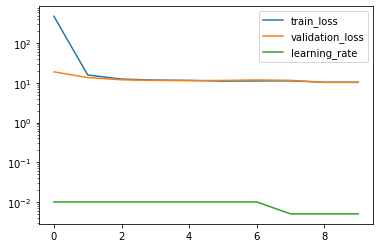

In [7]:
#example cosmosis/qchem PyG dataset wrapper with custum transform with
#dictionary output and custom model
import numpy as np

class IndexTransform():
    #select index i from dataset with multiple target outputs
    def __init__(self, i):
        self.i = i
    def __call__(self, arr):
        return np.reshape(arr[self.i], (1,))

model_params = {'in_channels': 319, 
                'hidden': 512, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'dataset': 'QM9',
                              'use_pyg': False,
                              'pad': (29,11),
                              'pad_feats': ['x'],
                              'flatten': True,
                              'target_transform': [IndexTransform(1)],
                              'input_dict': {'model_input': {'X': ['x']},
                                             'criterion_input': {'target': ['y']}},
                              'pg_params': {'root': './data/'}}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

l = Learn([PGDS], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=256, epochs=10)

CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:01.410725
epoch: 0, lr: 0.01
train loss: 1531.2388787520558, val loss: 1501.6782531738281
learning time: 0:00:11.455696
epoch: 8, lr: 0.01
train loss: 40.166971708598886, val loss: 40.18150806427002
learning time: 0:00:13.982745
epoch: 10, lr: 0.01
train loss: 37.44237458078485, val loss: 35.43085956573486
learning time: 0:00:25.160063
epoch: 19, lr: 0.005
train loss: 31.270781667608965, val loss: 30.584493160247803
test loss: 32.231781005859375
learning time: 0:00:25.661550


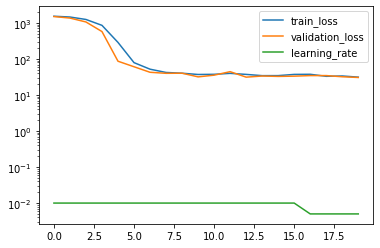

In [8]:
#example using cosmosis/qchem QM7 dataset and custom model
model_params = {'in_channels': 23*23, 
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['ae']}},
                              'in_file': './data/qm7/qm7.mat',
                              'flatten': True}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 3,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM7], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=256, epochs=20)

CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:01.200439
epoch: 0, lr: 0.01
train loss: 1558.6392436780427, val loss: 1531.7764282226562
learning time: 0:00:11.550224
epoch: 9, lr: 0.01
train loss: 52.21099170885588, val loss: 56.516178131103516
learning time: 0:00:12.670290
epoch: 10, lr: 0.01
train loss: 48.410750941226354, val loss: 56.803677558898926
learning time: 0:00:22.994689
epoch: 19, lr: 0.01
train loss: 41.331789920204564, val loss: 48.871891021728516
test loss: 48.69622802734375
learning time: 0:00:23.473723


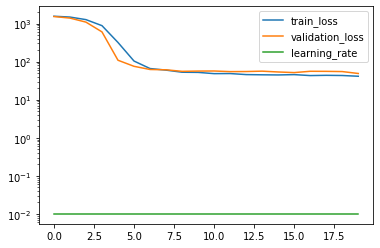

In [9]:
#example using the cosmosis/qchem QM7b dataset and custom model
model_params = {'in_channels': 23*23, 
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['E']}},
                              'in_file': './data/qm7b/qm7b.mat',
                              'flatten': True}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 3,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM7b], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params, 
          batch_size=256, epochs=20)

In [11]:
#example exploring cosmosis/qchem QM7X dataset

features = ['DIP','HLgap','atC6','atNUM','atPOL','atXYZ','eAT','hDIP',
            'eC','eDFTB+MBD','eEE','eH','eKIN','eKSE','eL','eMBD','eNE', 
            'eNN','ePBE0','ePBE0+MBD','eTS','eX','eXC','eXX','hCHG', 
            'hRAT','hVDIP','hVOL','mC6','mPOL','mTPOL','pbe0FOR', 
            'sMIT','sRMSD','totFOR','vDIP','vEQ','vIQ','vTQ','vdwFOR','vdwR',
            'coulomb'] #(1110,) with pad=23

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['atNUM']},
                                             'criterion_input': {'target': ['eAT']}},
                              'pad': None, #longest molecule = 23
                              'as_tensor': False,
                              'n': 1000, #non-random subset for testing
                              'selector': ['opt'],
                              'flatten': True}}

qm7x = QM7X(**ds_params['train_params'])

l, m = 0, 0
for i in qm7x.ds_idx:
    s = qm7x[i]['model_input']['X'].shape[0]
    if s > l:
        l = s
        m = i
print('longest molecule length: ', l, ' index: ', m)
print(qm7x[m]['model_input']['X'].shape) 
qm7x[m]


mapping...  <HDF5 file "1000.hdf5" (mode r)>
mapping...  <HDF5 file "2000.hdf5" (mode r)>
mapping...  <HDF5 file "3000.hdf5" (mode r)>
mapping...  <HDF5 file "4000.hdf5" (mode r)>
mapping...  <HDF5 file "5000.hdf5" (mode r)>
mapping...  <HDF5 file "6000.hdf5" (mode r)>
mapping...  <HDF5 file "7000.hdf5" (mode r)>
mapping...  <HDF5 file "8000.hdf5" (mode r)>
molecular formula (idmol) mapped:  1000
total molecular structures (idconf) mapped:  3723
CDataset created...
longest molecule length:  20  index:  233
(20,)


{'model_input': {'X': array([6., 6., 6., 6., 6., 6., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1.], dtype=float32)},
 'criterion_input': {'target': array([89.31956], dtype=float32)}}

mapping...  <HDF5 file "1000.hdf5" (mode r)>
mapping...  <HDF5 file "2000.hdf5" (mode r)>
mapping...  <HDF5 file "3000.hdf5" (mode r)>
mapping...  <HDF5 file "4000.hdf5" (mode r)>
mapping...  <HDF5 file "5000.hdf5" (mode r)>
mapping...  <HDF5 file "6000.hdf5" (mode r)>
mapping...  <HDF5 file "7000.hdf5" (mode r)>
mapping...  <HDF5 file "8000.hdf5" (mode r)>
molecular formula (idmol) mapped:  1000
total molecular structures (idconf) mapped:  3723
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:01.167692
epoch: 0, lr: 0.01
train loss: 64.46774215698242, val loss: 61.56050682067871
test loss: 4.095234036445618
learning time: 0:00:11.294766


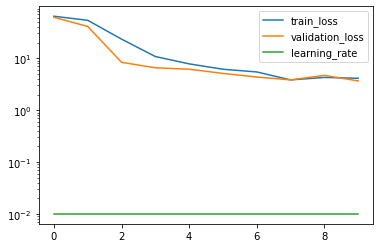

In [10]:
#example using the cosmosis/qchem QM7X dataset with filter and custom model
model_params = {'in_channels': 23*23,
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

features = ['DIP','HLgap','atC6','atNUM','atPOL','atXYZ','hDIP','eAT',
            'eC','eDFTB+MBD','eEE','eH','eKIN','eKSE','eL','eMBD','eNE', 
            'eNN','ePBE0','ePBE0+MBD','eTS','eX','eXC','eXX','hCHG', 
            'hRAT','hVDIP','hVOL','mC6','mPOL','mTPOL','pbe0FOR', 
            'sMIT','sRMSD','totFOR','vDIP','vEQ','vIQ','vTQ','vdwFOR','vdwR',
            'coulomb','distance']

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['eAT']}},
                              'pad': 23,
                              'selector': ['opt'],
                              'flatten': True,
                              'n': 1000, #non-random subset for testing
                             }}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15),
                 #'subset': .2 #create random subset
                } 

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM7X], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=64, epochs=10)

molecules loaded:  1000
molecules loaded:  2000
molecules loaded:  3000
molecules loaded:  3114
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:01.904432
epoch: 0, lr: 0.01
train loss: 546.5347675996668, val loss: 461.01753888811385
learning time: 0:00:12.390501
epoch: 6, lr: 0.01
train loss: 33.97229912701775, val loss: 28.863830293927872
test loss: 29.177114486694336
learning time: 0:00:18.352502


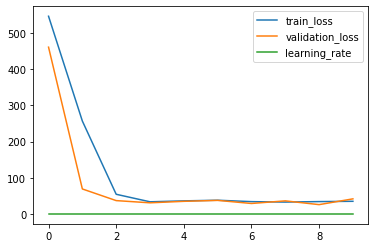

In [11]:
#example using cosmosis/qchem ANI1x dataset with filter and custom model
model_params = {'in_channels': 63*63, 
                'hidden': 2000, 
                'out_channels': 1, 
                'model_name': 'funnel'
               }

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['wb97x_dz.energy']}},
                              'pad_feats': ['coulomb'],
                              'pad': 63, #length of the longest molecule in the dataset
                              'flatten': True,
                              'criterion': ['wb97x_dz.energy'],
                              'conformation': 'max',
                              'in_file': './data/ani1x/ani1x-release.h5'}}

metrics_params = {'report_interval': 20}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}
sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}
opt_params = {'lr': 0.01}

l = Learn([ANI1x], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          batch_size=64, epochs=10)

In [12]:
!conda list

# packages in environment at /home/operat0r/miniconda3/envs/qchem:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                        main  
_openmp_mutex             4.5                       1_gnu  
anyio                     3.4.0            py38h578d9bd_0    conda-forge
argon2-cffi               20.1.0           py38h27cfd23_1  
async_generator           1.10                       py_0    conda-forge
attrs                     21.2.0             pyhd8ed1ab_0    conda-forge
babel                     2.9.1              pyh44b312d_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports                 1.0                        py_2    conda-forge
backports.functools_lru_cache 1.6.4              pyhd8ed1ab_0    conda-forge
blas                      1.0                         mkl  
bleach                    4.1.0              pyhd8ed1ab_0    conda-forge
boost                     1.70.0    